In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def parse_log(file):
    match_number = re.compile('-?\ *[0-9]+\.?[0-9]*(?:[Ee]\ *-?\ *[0-9]+)?')
    with open(file) as f:
        contents = f.readlines()
    times = []
    metrics = []
    testing = []
    keep = []
    i=0
    for x in contents:
        if i == 0:
            value = re.findall(match_number, x)
            keep.append(value[0])
            i+=1
        if "Time" in x:
            value = re.findall(match_number, x)
            value = [float(v) for v in value]
            key = re.findall(r'connect_to_workers|UpdateWeight|BroadcastUpdate|ComputeAccuracy|StartComputation|Training', x)[0]
            times.append([key, value[0], value[1]])
        if "Metric" in x:
            value = re.findall(match_number, x)
            value = [float(v) for v in value]
            if 'Training' in x:
                metrics.append([value[0], value[1], value[2], value[3]])
            if 'Testing' in x:
                testing.append([value[0], value[1], value[2]])
    
    value = re.findall(match_number, x)
    keep.append(value[0])
    t = float(keep[1]) - float(keep[0])
    return pd.DataFrame(times, columns=['Function', 'Timestamp', 'Duration']), \
         pd.DataFrame(metrics, columns=['Timestamp', 'Iteration', 'TrainingLoss', 'WeightSize']), \
         pd.DataFrame(testing, columns=['Timestamp', 'Accuracy', 'NbrSamples']), t
        

In [3]:
from os import listdir
from os.path import isfile, join

def parse_all_files(folder):
    onlyfiles = [folder+f for f in listdir(folder) if isfile(join(folder, f))]
    concat_time = []
    concat_metrics = []
    concat_testing = []
    times = []
    for i, file in enumerate(onlyfiles):
        if file[-3:] == "txt":
            time, metrics, testing, t = parse_log(file)
            time['Worker'] = i
            metrics['Worker'] = i
            testing['Worker'] = i
            concat_time.append(time)
            concat_metrics.append(metrics)
            concat_testing.append(testing)
            times.append(t)
    return pd.concat(concat_time), pd.concat(concat_metrics), pd.concat(concat_testing), times

In [4]:
def plot_timesSpent(metrics):
    for metric in metrics:
        times_worker = metrics.groupby('Worker')['Timestamp'].max() - metrics.groupby('Worker')['Timestamp'].min()
        plt.title('Time of computation for each worker')
        times_worker.plot(kind='bar')
        plt.show()

In [5]:
def get_function_graphs(times):
    counts = times.groupby(['Function', 'Worker']).count()
    counts.reset_index(level=1, inplace=True)
    counts.reset_index(level=0, inplace=True)
    f = sns.factorplot(data=counts, kind='bar', x='Function',y='Duration', hue='Worker')
    f.ax.set_title("Number of function calls by function an Worker")
    plt.show()

In [6]:
def plot_metrics(metrics):
    plt.title('Training loss mean over time')
    metrics['Mean'] = pd.rolling_mean(metrics['TrainingLoss'], window=100)
    metrics.groupby('Worker')['Mean'].plot()
    plt.show()
    
def plot_weightsize(metrics):
    plt.title('Increase of weight size')
    metrics.groupby('Worker')['WeightSize'].plot()
    plt.show()
    
def plt_raw_loss(metrics):
    plt.title('Training loss over time')
    metrics.groupby('Worker')['TrainingLoss'].plot()
    plt.show()

Get current calculation to see when finishes

In [62]:
times, metrics, tests, t = parse_all_files('./')
#metrics.set_index('Timestamp', inplace=True)
metrics['Mean'] = pd.rolling_mean(metrics['TrainingLoss'], window=50)
metrics.groupby('Worker')['Iteration'].max()

/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  app.launch_new_instance()


Worker
2     3172.0
3     3160.0
4     3046.0
5     3120.0
6     2679.0
7     3006.0
9     2733.0
10    3170.0
11    3150.0
12    3132.0
Name: Iteration, dtype: float64

Plotting out data:

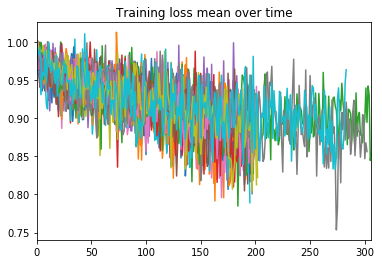

In [8]:
plt.title('Training loss mean over time')
metrics.groupby('Worker')['TrainingLoss'].plot()
plt.show()

/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()
  app.launch_new_instance()


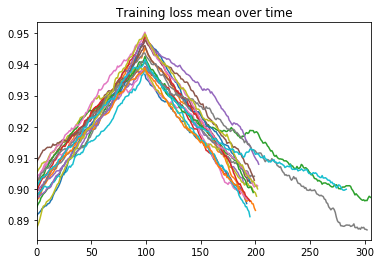

,Timestamp,Iteration,TrainingLoss,WeightSize,Worker,Mean
279,1.784743e+06,279.0,0.862692,38163.0,22,0.899973
280,1.785117e+06,280.0,0.859409,38195.0,22,0.899690
281,1.785510e+06,281.0,0.879071,38234.0,22,0.899596
282,1.785876e+06,282.0,0.945742,38314.0,22,0.899753
283,1.786309e+06,283.0,0.963449,38362.0,22,0.899929


In [9]:
plot_metrics(metrics)
metrics.tail()

# Finding the learning rate (done with asynch system)

We should use learning rate 1:

In [10]:
metrics = []
rates = [1, 0.1, 0.01, 0.001]
for lr in rates:
    times, metric, tests, t = parse_all_files('./learningratefinding/asynch_lr_'+str(lr)+'/')
    metric['Mean'] = pd.rolling_mean(metric['TrainingLoss'], window=50)
    metrics.append(metric)

/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()


/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  app.launch_new_instance()


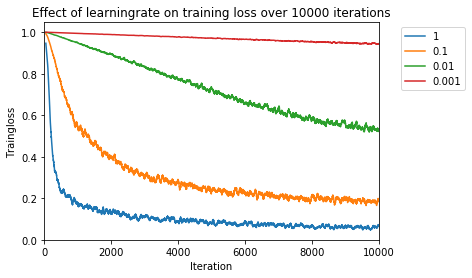

In [11]:
means = []
for metric in metrics:
    pd.rolling_mean(metric.groupby(['Iteration'])['TrainingLoss'].mean(), window=50).plot()
    plt.title('Effect of learningrate on training loss over 10000 iterations')
    plt.ylabel('Traingloss')
    plt.legend(rates, bbox_to_anchor=(1.05, 1))

# Getting the best batch size:

Done with looking at asynch

/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()


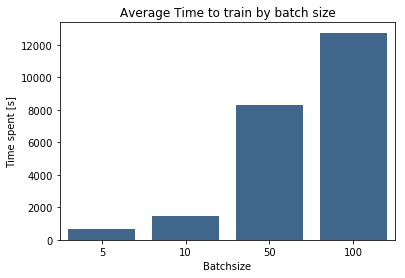

In [12]:
metrics = []
batchsizes = [5, 10, 50, 100]
for batchsize in batchsizes:
    times, metric, tests, t = parse_all_files('./batchsizefinding/asynchbatchsize'+str(batchsize)+'lr1/')
    metric['Mean'] = pd.rolling_mean(metric['TrainingLoss'], window=50)
    metrics.append(metric)

means = []
for metric in metrics:
    times_worker = metric.groupby('Worker')['Timestamp'].max() - metric.groupby('Worker')['Timestamp'].min()
    means.append(times_worker.mean())

plt.title('Average Time to train by batch size')
plt.xlabel('Batchsize')
plt.ylabel('Time spent [s]')
sns.barplot(y = means, x = batchsizes, color='#336699')

/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  app.launch_new_instance()


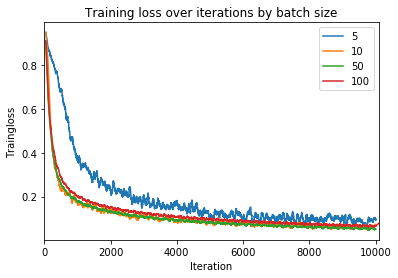

In [13]:
means = []
for metric in metrics:
    pd.rolling_mean(metric.groupby(['Iteration'])['TrainingLoss'].mean(), window=50).plot()
    plt.title('Training loss over iterations by batch size')
    plt.ylabel('Traingloss')
    plt.legend(batchsizes)

/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
  if __name__ == '__main__':


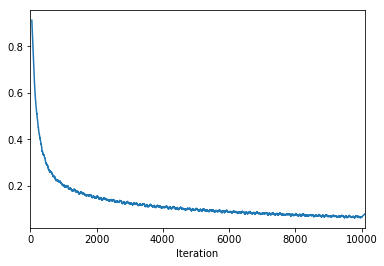

In [14]:
pd.rolling_mean(metric.groupby(['Iteration'])['TrainingLoss'].mean(), window=50).plot()

# Looking at Synch vs Asynch:

Compare mean time, and shortest time per worker, make sure to only take worker who did full iterations

In [15]:
def get_metrics(path="./synch_exec/synchbatchsize10lr1worker"):
    metrics = []
    workers = [2, 4, 10]
    for worker in workers:
        times, metric, tests, t = parse_all_files(path+str(worker)+'/')
        metric['Mean'] = pd.rolling_mean(metric['TrainingLoss'], window=50)
        metrics.append(metric)
    return metrics

In [57]:
def plot_time_spent(metrics):
    means = []
    for metric in metrics:
        times_worker = metric.groupby('Worker')['Timestamp'].max() - metric.groupby('Worker')['Timestamp'].min()
        means.append(times_worker.mean())

    plt.title('Average Time to train by number of workers')
    plt.xlabel('nbr workers')
    plt.ylabel('Time spent [s]')
    sns.barplot(y = means, x = list(range(len(means))))

In [17]:
def plot_learning(metrics, selection = [0, 1, 2]):
    means = []
    for i, metric in enumerate(metrics):
        if i in selection:
            pd.rolling_mean(metric.groupby(['Iteration'])['TrainingLoss'].mean(), window=50).plot()
            plt.title('Training loss over iterations by numbre of workers')
            plt.ylabel('Traingloss')
            plt.legend()

In [21]:
def plot_lr(metrics, selection = [0, 1, 2]):
    means = []
    for i, metric in enumerate(metrics):
        if i in selection:
            mins = metric.groupby('Worker')['Timestamp'].min()
            mins.name = 'Min'
            me = metric.join(mins,on='Worker', how='inner')
            me['Timestamp'] = me['Timestamp'] - me['Min']
            #me = me[me['Timestamp'] < 2000]
            pd.rolling_mean(me.groupby(['Timestamp'])['TrainingLoss'].mean(), window=100).plot(alpha=0.5)
            plt.title('Training loss over iterations by numbre of workers')
            plt.ylabel('Traingloss')
            plt.legend(selection)

In [19]:
synch = get_metrics()
asy = get_metrics('./asynch_exec/asynchbatchsize10lr1worker')

/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()


/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()


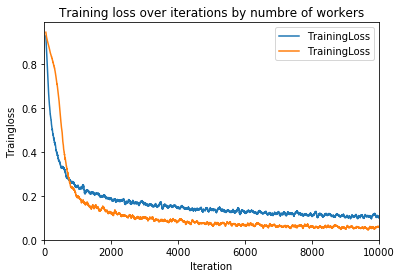

/Users/lguillain/anaconda/envs/ada/lib/python3.5/site-packages/ipykernel/__main__.py:10: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=100,center=False).mean()


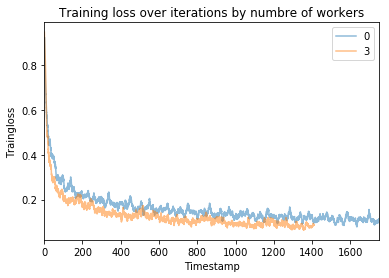

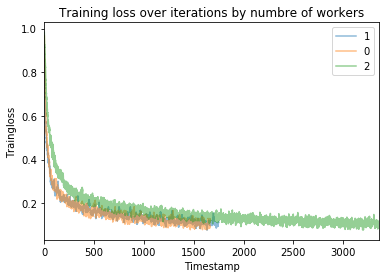

In [22]:
plot_learning(synch, [2])
plot_learning(asy, [2])

plt.show()

plot_lr(synch+asy, [0, 3])
plt.show()
plot_lr(synch+asy, [1, 0,2])

In [59]:
array=asy
for metrics in array:
    print(metrics.groupby('Worker')['Iteration'].max())

Worker
0    10000.0
1    10000.0
Name: Iteration, dtype: float64
Worker
1    10000.0
2    10000.0
3    10000.0
4    10000.0
Name: Iteration, dtype: float64
Worker
1     10000.0
2     10000.0
3     10000.0
4     10000.0
5     10000.0
6     10000.0
7      4860.0
8     10000.0
9     10000.0
10    10000.0
Name: Iteration, dtype: float64


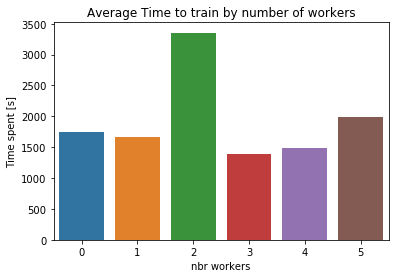

In [58]:
plot_time_spent(synch+asy)

In [24]:
def get_messages(path="./synch_exec/synchbatchsize10lr1worker"):
    metrics = []
    workers = [2, 4, 10]
    for worker in workers:
        times, metric, tests, t = parse_all_files(path+str(worker)+'/')
        metrics.append(times)
    return metrics

In [25]:
def plot_wasted_time(times):
    total = []
    for time in times:
        total.append(time['Duration'].sum())
    plt.title('time spent in boadcast and update weight functions')
    plt.ylabel('Time [s]')
    sns.barplot(y=total, x= list(range(len(times))))
    
def plot_wasted_time_broadcast(times, spec='BroadcastUpdate'):
    total = []
    for time in times:
        total.append(time[time['Function'] == spec]['Duration'].sum())
    plt.title('time spent in boadcast and update weight functions')
    plt.ylabel('Time [s]')
    sns.barplot(y=total, x= list(range(len(times))))

In [27]:
synch_t = get_messages()
asynch_t = get_messages('./asynch_exec/asynchbatchsize10lr1worker')

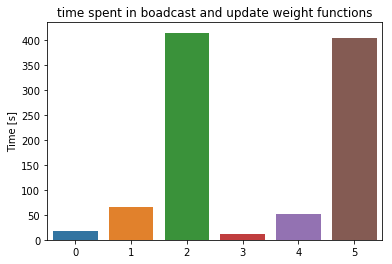

In [28]:
plot_wasted_time(synch_t+asynch_t)

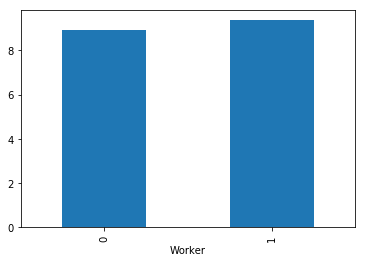

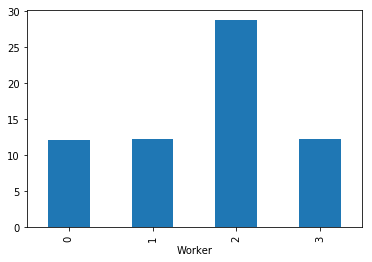

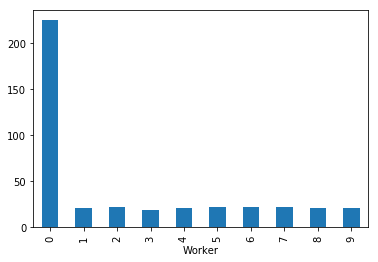

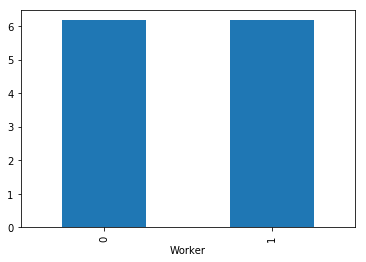

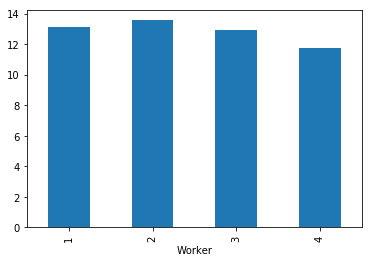

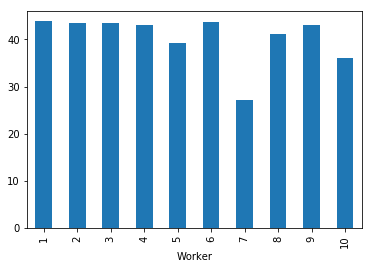

In [52]:
times=synch_t+asynch_t
for time in times:
    time.groupby('Worker')['Duration'].sum().plot(kind='bar')
    plt.show()

Broadcast


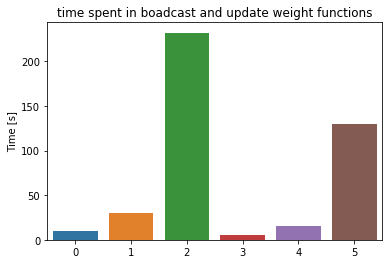

UpdateWeight


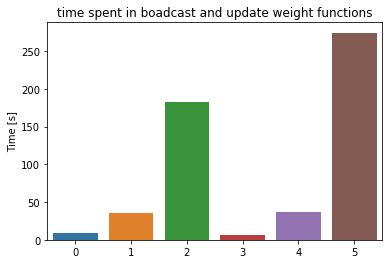

In [29]:
print('Broadcast')
plot_wasted_time_broadcast(synch_t+asynch_t)

plt.show()
print('UpdateWeight')
plot_wasted_time_broadcast(synch_t+asynch_t, 'UpdateWeight')

[0.9523241379500056, 0.9533500517987543, 0.9542953522348155, 0.9637320687341788, 0.9545570715734114, 0.9554046097335717, 0.958340681161628, 0.957642613233895, 0.956231774365426, 0.9637516425638589] [0.6736139344010088, 0.6744962282525375, 0.6755275933077145, 0.6758593847597432, 0.7043738838750222, 0.679854502050827, 0.26745977856943176, 0.6795720965611852, 0.6774608669155795, 0.6992127137574911]
